In [385]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import os
import pickle
import statistics
from sklearn.metrics import confusion_matrix
import requests, bs4
from sklearn.metrics import roc_curve, auc

Here I am going to run multiple models of each and try to tally average wins, average losses, and average profit. I will not update for 2019, I will predict 2019 off 17-18.

In [309]:
os.chdir('/Users/ahelgeso/Documents/GitHub/bball')

In [310]:
np.set_printoptions(threshold=np.nan)

In [408]:
db19 = pd.read_csv('2019stats.csv')
db = pd.read_csv('2017_2018stats.csv')

db19['Date'] = db19['Date'].apply(str)
db19['Date'] = pd.to_datetime(db19.Date, format = "%Y%m%d")
db19 = db19.sort_values(by = ['Date']).reset_index(drop = True)

In [409]:
feature3Cols = ['Location','Rolling3EFG','Rolling3TOV','Rolling3ORB','Rolling3FTR','Rolling3Pace','Opp R3Pace','Opp R3EFG','Opp R3TOV','Opp R3ORB','Opp R3FTR', 'Rolling3DEff', 'Opp R3 Deff', 'Rolling3OEff','Opp R3 Oeff']
feature9Cols = ['Location','Rolling9EFG','Rolling9TOV','Rolling9ORB','Rolling9FTR','Rolling9Pace','Opp R9Pace','Opp R9EFG','Opp R9TOV','Opp R9ORB','Opp R9FTR', 'Rolling9DEff', 'Opp R9 Deff', 'Rolling3OEff','Opp R3 Oeff']

target = ['Result']
X3 = db.dropna()[feature3Cols]
X9 = db.dropna()[feature9Cols]
y = np.array(db.dropna()[target]).flatten()

x9_train, x9_test, y9_train, y9_test = train_test_split(X9, y, test_size=0.3)
x3_train, x3_test, y3_train, y3_test = train_test_split(X3, y, test_size=0.3)

dogs2019 = db19[(db19['Line'] > 0)].dropna().reset_index()
Ydogs2019 = db19[(db19['Line'] > 0)].dropna()['Result']

Below is a voting classifier which combies an Adabooster and a gradient boosting classifier

In [414]:
x3_train, x3_test, y3_train, y3_test = train_test_split(X3, y, test_size=0.3)
ada3 = AdaBoostClassifier(n_estimators=50, learning_rate=0.1).fit(x3_train, y3_train)

x3_train, x3_test, y3_train, y3_test = train_test_split(X3, y, test_size=0.3)
gbc3 = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth = 1).fit(x3_train, y3_train)

eclf1 = VotingClassifier(estimators=[('ada', ada3), ('gbc', gbc3)], voting='soft')
eclf1 = eclf1.fit(x3_train, y3_train)
pred = eclf1.predict(dogs2019[feature3Cols])
win = confusion_matrix(Ydogs2019, pred)[1][1]
loss = confusion_matrix(Ydogs2019,pred)[0][1]
odds = []
for i, n in enumerate(pred):
    if n == 1:
        odds.append(dogs2019['Odds'][i])
avg_odds = statistics.mean(odds)
print("Average odds: ", avg_odds)
profit = (win * avg_odds) - (100 * loss)
total_bet = 100 * (win + loss)
ROI = profit/total_bet
print("ROI of stacked models:", ROI)
print(confusion_matrix(Ydogs2019, pred))


Average odds:  184
ROI of stacked models: 0.2580371352785146
[[506 210]
 [190 167]]


/Users/ahelgeso/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Voting Classifier can predict probabilities. The [:, 1] probability prediction column is probability of wins. The classifier is pretty aggressive picking dogs, so if you have a high probability difference it does a decent job of picking really heavy dogs.

In [415]:
probs = eclf1.predict_proba(dogs2019[feature9Cols])[:,1]
diffs = (probs * 100.0) - dogs2019['Implied Proba']

odds = [n for i, n in enumerate(dogs2019['Odds']) if diffs[i] > 0]

avg_odds = statistics.mean(odds)
profit = (win * avg_odds) - (100 * loss)
total_bet = 100 * (win + loss)
ROI = profit/total_bet

print('Profit: ', profit, 'ROI', ROI)

Profit:  26788.250258531538 ROI 0.710563667335054


In [416]:
db = []

for i, n in enumerate(dogs2019['Odds']):
    db.append({'Team': dogs2019['Team'][i], 'Opponent': dogs2019['Opponent'][i], 'Date': dogs2019['Date'][i],
               'Line': dogs2019['Line'][i], 'Odds': n, 'Result': dogs2019['Result'][i],
              'Prediction': pred[i], 'Predicted Win Prob': probs[i]*100.0, 
               'Implied Prob': dogs2019['Implied Proba'][i], 'Probability Difference': diffs[i]})
    
db = pd.DataFrame(db)
wins = len(db[(db['Prediction'] == 1) & (db['Result'] == 1)])
losses = len(db[(db['Prediction'] == 1) & (db['Result'] == 0)])

Probability Difference: 0 Wins: 158 Losses: 203 Avg Odds 286.1571871768356 ROI 0.6901062485855961
Highest Loss: 0   -100
dtype: int64
Total Winnings: 24912.83557394002
Total Risked: 36100
Probability Difference: 10 Wins: 99 Losses: 154 Avg Odds 357.4119402985075 ROI 0.7898728098637249
Highest Loss: 0   -100
dtype: int64
Total Winnings: 19983.782089552238
Total Risked: 25300
Probability Difference: 20 Wins: 43 Losses: 77 Avg Odds 490.66483516483515 ROI 1.1165489926739927
Highest Loss: 0   -300
dtype: int64
Total Winnings: 13398.58791208791
Total Risked: 12000


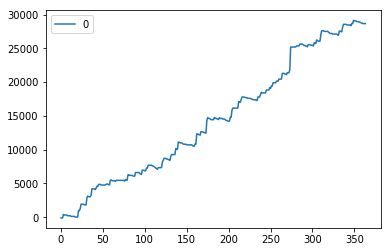

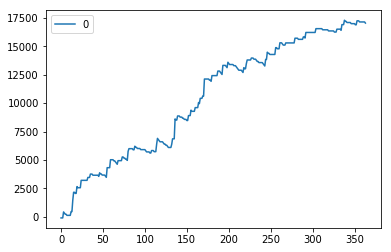

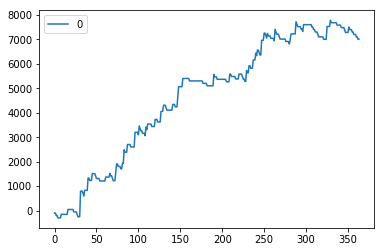

In [417]:
thresholds = [0, 10, 20]
for t in thresholds:
    db1 = db[db['Probability Difference'] > t].reset_index()
    wins = len(db1[(db1['Prediction'] == 1) & (db1['Result'] == 1)])
    losses = len(db1[(db1['Prediction'] == 1) & (db1['Result'] == 0)])
    avg_odds = statistics.mean(db1['Odds'])
    ROI = (wins * avg_odds - losses * 100) / ((wins + losses)*100)
    print('Probability Difference:', t, 'Wins:', wins, 'Losses:', losses, 'Avg Odds', avg_odds, 'ROI',ROI)
    
    earnings = []

    for i, n in enumerate(db1[db1['Probability Difference'] > 20]['Odds']):
        if db1['Prediction'][i] == 1 and db1['Result'][i] == 1:
            if n > 0:
                earnings.append(n)
            else:
                earnings.append(100/abs(n) * 100)
        elif db1['Prediction'][i] == 1 and db1['Result'][i] == 0:
            earnings.append(-100)
        else:
            earnings.append(0)
    pd.DataFrame(earnings).cumsum().plot()
    print("Highest Loss:", pd.DataFrame(earnings).cumsum().min())
    print("Total Winnings:", wins*avg_odds -losses*100)
    print("Total Risked:", (wins+losses)*100)

In [420]:
earnings = []

for i, n in enumerate(db1[db1['Probability Difference'] > 20]['Odds']):
    if db1['Prediction'][i] == 1 and db1['Result'][i] == 1:
        if n > 0:
            earnings.append(n)
        else:
            earnings.append(100/abs(n) * 100)
    elif db1['Prediction'][i] == 1 and db1['Result'][i] == 0:
        earnings.append(-100)
    else:
        earnings.append(0)

In [421]:
Game_Profit = pd.DataFrame(earnings)
Cum_Profit = pd.DataFrame(earnings).cumsum()

In [422]:
pd.concat([db1,Game_Profit,Cum_Profit], axis = 1).to_csv('RunningProfits202019.csv', index = False)

#### Above tracks running profits for 2019 on picks with probability difference above 20%

In [423]:
pd.read_csv('RunningProfits202019.csv')

,index,Date,Implied Prob,Line,Odds,Opponent,Predicted Win Prob,Prediction,Probability Difference,Result,Team,0,0.1
0,1,2018-11-03,26.315789,8.0,280,HOU,53.941454,1,27.625665,0,CHI,-100,-100
1,3,2018-11-04,19.047619,10.0,425,MIL,40.810036,0,21.762417,0,SAC,0,-100
2,6,2018-11-04,29.411765,6.5,240,WAS,56.790412,1,27.378647,0,NYK,-100,-200
3,13,2018-11-06,16.000000,11.0,525,CHO,43.943327,0,27.943327,0,ATL,0,-200
4,16,2018-11-07,22.988506,10.0,335,UTA,54.158328,1,31.169822,0,DAL,-100,-300
5,18,2018-11-07,24.213075,8.5,313,TOR,48.681037,0,24.467962,0,SAC,0,-300
6,19,2018-11-07,18.181818,10.0,450,NOP,51.120079,0,32.938261,0,CHI,0,-300
7,24,2018-11-08,21.505376,9.5,365,BOS,49.849623,0,28.344247,0,PHO,0,-300
8,29,2018-11-09,40.816327,3.5,145,MIN,63.015166,1,22.198840,1,SAC,145,-155
9,33,2018-11-09,20.000000,9.5,400,DEN,50.009883,0,30.009883,1,BRK,0,-155


In [171]:
#db19.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1, inplace = True)
db19['Date'] = db19['Date'].apply(str)
db19['Date'] = pd.to_datetime(db19.Date, format = "%Y%m%d")
db19 = db19.sort_values(by = ['Date']).reset_index(drop = True)

db['Date'] = db['Date'].apply(str)
db['Date'] = pd.to_datetime(db.Date, format= "%Y%m%d")
db = db.sort_values(by = ['Date']).reset_index(drop = True)
test = pd.concat([db, db19[:int(len(db19)/2)]], ignore_index = True)

# Leave in first half of prev season or cut it out?

test = test.drop(test.index[:int(len(db19)/2)]) 
db = test.reset_index(drop = True) ### for simplicity
db = db.drop(['Implied Prob','Implied Proba'], axis = 1)

dogs2019 = db19[int(len(db19)/2):][db19['Line'] > 0].dropna().reset_index()
Ydogs2019 = db19[int(len(db19)/2):][db19['Line'] > 0].dropna()['Result']

feature3Cols = ['Location','Rolling3EFG','Rolling3TOV','Rolling3ORB','Rolling3FTR','Rolling3Pace','Opp R3Pace','Opp R3EFG','Opp R3TOV','Opp R3ORB','Opp R3FTR', 'Rolling3DEff', 'Opp R3 Deff', 'Rolling3OEff','Opp R3 Oeff']
feature9Cols = ['Location','Rolling9EFG','Rolling9TOV','Rolling9ORB','Rolling9FTR','Rolling9Pace','Opp R9Pace','Opp R9EFG','Opp R9TOV','Opp R9ORB','Opp R9FTR', 'Rolling9DEff', 'Opp R9 Deff', 'Rolling3OEff','Opp R3 Oeff']

target = ['Result']
X3 = db.dropna()[feature3Cols]
X9 = db.dropna()[feature9Cols]
y = np.array(db.dropna()[target]).flatten()

x9_train, x9_test, y9_train, y9_test = train_test_split(X9, y, test_size=0.3)
x3_train, x3_test, y3_train, y3_test = train_test_split(X3, y, test_size=0.3)

ValueError: time data '2018-10-16 00:00:00' does not match format '%Y%m%d' (match)

In [307]:
res = []

#ada9 = AdaBoostClassifier(n_estimators=50, learning_rate=0.1).fit(x9_train, y9_train)
#ada3 = AdaBoostClassifier(n_estimators=50, learning_rate=0.1).fit(x3_train, y3_train)

model = "GBC9"
features = "9 Game"
wins = []
losses = []
ROIs = []

for i in range(0,20):
    x9_train, x9_test, y9_train, y9_test = train_test_split(X9, y, test_size=0.3)
    gbc9 = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=1).fit(x9_train, y9_train)
    pred = gbc9.predict(dogs2019[feature9Cols])
    win = confusion_matrix(Ydogs2019, pred)[1][1]
    loss = confusion_matrix(Ydogs2019,pred)[0][1]
    odds = []
    for i, n in enumerate(pred):
        if n == 1:
            odds.append(dogs2019['Odds'][i])
    avg_odds = statistics.mean(odds)
    profit = (win * avg_odds) - (100 * loss)
    total_bet = 100 * (win + loss)
    ROI = profit/total_bet
    wins.append(win)
    losses.append(loss)
    ROIs.append(ROI)

    res.append({"Model": model, "Features": features, "Wins":win, "Losses":loss, "Avg Odds":avg_odds, "ROI": ROI})
    
print('Model:', model, 'Avg wins:',statistics.mean(wins), 'Avg losses:', statistics.mean(losses), 'Avg ROI:', statistics.mean(ROIs))

model = "GBC3"
features = "3 Game"
wins = []
losses = []
ROIs = []

for i in range(0,20):
    x3_train, x3_test, y3_train, y3_test = train_test_split(X3, y, test_size=0.3)
    gbc3 = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=1).fit(x3_train, y3_train)
    pred = gbc3.predict(dogs2019[feature3Cols])
    win = confusion_matrix(Ydogs2019, pred)[1][1]
    loss = confusion_matrix(Ydogs2019,pred)[0][1]
    odds = []
    for i, n in enumerate(pred):
        if n == 1:
            odds.append(dogs2019['Odds'][i])
    avg_odds = statistics.mean(odds)
    profit = (win * avg_odds) - (100 * loss)
    total_bet = 100 * (win + loss)
    ROI = profit/total_bet
    wins.append(win)
    losses.append(loss)
    ROIs.append(ROI)

    res.append({"Model": model, "Features": features, "Wins":win, "Losses":loss, "Avg Odds":avg_odds, "ROI": ROI})
    
print('Model:', model, 'Avg wins:',statistics.mean(wins), 'Avg losses:', statistics.mean(losses), 'Avg ROI:', statistics.mean(ROIs))


model = "ADA9"
features = "9 Game"
wins = []
losses = []
ROIs = []

for i in range(0,20):
    x9_train, x9_test, y9_train, y9_test = train_test_split(X9, y, test_size=0.3)
    ada9 = AdaBoostClassifier(n_estimators=50, learning_rate=0.1).fit(x9_train, y9_train)
    pred = ada9.predict(dogs2019[feature9Cols])
    win = confusion_matrix(Ydogs2019, pred)[1][1]
    loss = confusion_matrix(Ydogs2019,pred)[0][1]
    odds = []
    for i, n in enumerate(pred):
        if n == 1:
            odds.append(dogs2019['Odds'][i])
    avg_odds = statistics.mean(odds)
    profit = (win * avg_odds) - (100 * loss)
    total_bet = 100 * (win + loss)
    ROI = profit/total_bet
    wins.append(win)
    losses.append(loss)
    ROIs.append(ROI)

    res.append({"Model": model, "Features": features, "Wins":win, "Losses":loss, "Avg Odds":avg_odds, "ROI": ROI})
    
print('Model:', model, 'Avg wins:',statistics.mean(wins), 'Avg losses:', statistics.mean(losses), 'Avg ROI:', statistics.mean(ROIs))


model = "ADA3"
features = "3 Game"
wins = []
losses = []
ROIs = []

for i in range(0,20):
    x3_train, x3_test, y3_train, y3_test = train_test_split(X3, y, test_size=0.3)
    ada3 = AdaBoostClassifier(n_estimators=50, learning_rate=0.1).fit(x3_train, y3_train)
    pred = ada3.predict(dogs2019[feature3Cols])
    win = confusion_matrix(Ydogs2019, pred)[1][1]
    loss = confusion_matrix(Ydogs2019,pred)[0][1]
    odds = []
    for i, n in enumerate(pred):
        if n == 1:
            odds.append(dogs2019['Odds'][i])
    avg_odds = statistics.mean(odds)
    profit = (win * avg_odds) - (100 * loss)
    total_bet = 100 * (win + loss)
    ROI = profit/total_bet
    wins.append(win)
    losses.append(loss)
    ROIs.append(ROI)

    res.append({"Model": model, "Features": features, "Wins":win, "Losses":loss, "Avg Odds":avg_odds, "ROI": ROI})
    
print('Model:', model, 'Avg wins:',statistics.mean(wins), 'Avg losses:', statistics.mean(losses), 'Avg ROI:', statistics.mean(ROIs))

pd.DataFrame(res)

Model: GBC9 Avg wins: 120 Avg losses: 173 Avg ROI: 0.07765635074276815
Model: GBC3 Avg wins: 146 Avg losses: 192 Avg ROI: 0.2108533644771892
Model: ADA9 Avg wins: 134 Avg losses: 190 Avg ROI: 0.10286164380245166
Model: ADA3 Avg wins: 157 Avg losses: 203 Avg ROI: 0.25354271868707484


,Avg Odds,Features,Losses,Model,ROI,Wins
0,159,9 Game,191,GBC9,0.009521,122
1,163,9 Game,170,GBC9,0.088276,120
2,149,9 Game,169,GBC9,0.043918,122
3,168,9 Game,189,GBC9,0.077089,127
4,150,9 Game,184,GBC9,0.035032,130
5,178,9 Game,168,GBC9,0.180548,124
6,172,9 Game,185,GBC9,0.037057,114
7,162,9 Game,156,GBC9,0.083459,110
8,159,9 Game,179,GBC9,0.079870,128
9,163,9 Game,183,GBC9,0.041584,120
